# Barotropic to baroclinic conversion
Following Nycander (2005) and Zilberman et al. (2009)

TODO, compare:
 - topo from LUCKY (750m)
 - topo from SRTM30_PLUS (30'')
 - topo from TPXO8
 
Details:
- tidal current are expressed in the grid of the topo (rotated)
- Convention, angles positive cc-wise: 
 -- for grid angle from xi to E ; 
 -- for INC from E to semi-major axis

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.basemap import Basemap
import scipy.interpolate as interp
import scipy.signal as signal
import scipy.stats as stats
from netCDF4 import Dataset
import time
from datetime import datetime

#from SW_Density import SW_Density as rhop # temporary
from comp_rho import rhop
#from distance_sphere_matproof import dist_sphere_matproof
from convert_TPXO_to_ellipses import get_tpxo7_on_grid, get_tpxo8_on_grid, rot_uv
from pad_coords import pad_coords   # for padding fields outside of domain
from detrend_2d import detrend_2d
from PyFVCOM import tidal_ellipse as ellipse

doverb = True


In [2]:
# --- data location ---
path_data = '/data0/project/vortex/lahaye/Tide_Conv/input_data/' #'./input_data/' #
path_data = '/net/krypton'+path_data     # if not on LOPS hub
path_alpha = '/net/alpha/exports/sciences/data/REFERENCE_DATA/'

# --- climato ---
clim = "lucky"
if clim == "lucky":
    cname = path_data+"lucky_ts_meanSODA_winter.nc"

# --- topography dataset --- 
topo = "lucky" # "tpxo" # "srtm"
if topo == 'lucky':
    file_topo = path_data+"lucky_corgrd.nc"
    varx, vary = 'lon_rho', 'lat_rho'
    varh = 'h'
elif topo == 'srtm':
    file_topo = TODO
    varx, vary = TODO
    varh = TODO
elif topo == 'tpxo8':
    file_topo = TODO
    varx, vary = TODO
    varh = TODO

# --- tide dataset --- 
tide = 'tpxo8' #'tpxo7' #

if tide == 'lucky':
    uname = path_data+'luckym2_frc.nc' 
elif tide == "tpxo7":
    uname = path_alpha+"TIDES/TPXO7.2/u_tpxo7.2.nc"
    gname = uname.replace("u","grid")
elif tide == 'tpxo8':
    uname = path_alpha+"TIDES/TPXO8/uv.m2_tpxo8_atlas_30c_v1.nc"
    gname = uname.replace("uv.m2","grid")
    
zmin       = -100              # min depth to compute Ef [m], below contin. shelf roughly
g          = 9.81              # gravity [m s-2]
M2         = 2*np.pi/12.42          # M2 tide frequency [rad/hour] 
Erad = 6371e3                  # Earth radius [m]

In [3]:
# ------ get mean topo on the grid, will be used to get N2b --------
# load the entire grid (regional modelling purpose)
nc   = Dataset(file_topo,'r') # etopo2 and srtm30 files have the same structure
if topo == 'lucky':
    lon_h = nc.variables[varx][:].T
    lat_h = nc.variables[vary][:].T
    nlon_h, nlat_h = lon_h.shape
    h_t = -nc.variables[varh][:].T
    h_t[h_t>=-2.5] = 0     # land points   # "raw" topo (for FFT)
    h_ma = np.ma.masked_where(h_t==0,-h_t) # masked topo
    dx_h = 1/nc.variables['pm'][:].T
    dy_h = 1/nc.variables['pn'][:].T
    gang = nc.variables['angle'][:].T # grid angle (rad., between xi (origin) and E, pos. cc-wise)
nc.close()

dhdx, dhdy = np.gradient(h_t,dx_h.mean(),dy_h.mean())

fcor = 2.*(2*np.pi/24.)*np.sin(lat_h*np.pi/180.) # coriolis, rad/hour

In [4]:
# ------ extract Tides ------------------------------

if tide == 'lucky':
    nc = Dataset(uname,'r')
    # angle between major axis and east [rad] (beware sign)
    phi = nc.variables['tide_Cangle'][0,...].T
    # tide phase ()
    pha = nc.variables['tide_Cphase'][0,...].T
    # tidal current amplitude (major, minor axes)
    ue = nc.variables['tide_Cmax'][0,...].T
    ve = nc.variables['tide_Cmin'][0,...].T
    nc.close()
    ubt,uphi,vbt,vphi, _ = ellipse.ep2ap(ue,ve/ue,phi+np.rad2deg(phi),pha)  # INC+grang correct ?
    del phi, ue, ve
elif tide == 'tpxo7':
    ubt, uphi, vbt, vphi = get_tpxo7_on_grid([uname,gname],lon_h,lat_h,grang=gang) 
elif tide == 'tpxo8':
    ubt, uphi, vbt, vphi = get_tpxo8_on_grid([uname,gname],lon_h,lat_h,grang=gang) 

pha = np.deg2rad(vphi-uphi)
del uphi, vphi


/home/lahaye/working_on/Int_Tide_Conv/convert_TPXO_to_ellipses.py:184: RuntimeWarning: invalid value encountered in true_divide
  ure = nc.variables['uRe'][indxu,indyu]*1e-4/hu    # cm²/s to m/s
/home/lahaye/working_on/Int_Tide_Conv/convert_TPXO_to_ellipses.py:185: RuntimeWarning: invalid value encountered in true_divide
  vre = nc.variables['vRe'][indxv,indyv]*1e-4/hv
/home/lahaye/working_on/Int_Tide_Conv/convert_TPXO_to_ellipses.py:186: RuntimeWarning: invalid value encountered in true_divide
  uim = nc.variables['uIm'][indxu,indyu]*1e-4/hu
/home/lahaye/working_on/Int_Tide_Conv/convert_TPXO_to_ellipses.py:187: RuntimeWarning: invalid value encountered in true_divide
  vim = nc.variables['vIm'][indxv,indyv]*1e-4/hv


In [5]:
# ------ extract density profile, compute N2 ------------------
if clim == "lucky":
    nc = Dataset(cname,'r')
    T = nc.variables['temp_roms_avg'][:]
    S = nc.variables['salt_roms_avg'][:]
    zz = nc.variables['depth'][:]
    nz = zz.size
    
rho = np.sort(rhop(T,S)) #SW_Density(T,S) # sorting is cheating here
rho0 = rho.mean()
frho = interp.pchip(zz[::-1],rho[::-1],extrapolate=True)
N2_tmp = -(g/rho0)*frho.derivative()(zz)    # take routine
# temporary fixing:
if N2_tmp[-1]==0: N2_tmp[-1] = 1e-8    # this is a dirty fix
indneg, = np.where(N2_tmp<=0.)
for ii in indneg:
    N2_tmp[ii] = (N2_tmp[ii-1] + N2_tmp[ii+1])/2
fN2 = interp.pchip(zz[::-1],N2_tmp,extrapolate=True)    


# fit exponential profile
slope,intercept,r_val,p_val,std_err = stats.linregress(zz,np.log(N2_tmp**0.5))
N0  = np.exp(intercept)
b   = 1./slope
N2b = np.sqrt(fN2(h_t))

if doverb:
    if indneg.size>0:
        print('had to resort stratif for {} values'.format(indneg.size))
    print('exponential interpolation for stratification: N0={0}, b={1}'.format(N0,b))
    
coef = rho0*N2b/2*np.sqrt(1-fcor**2/M2**2)

def kn_expN(n,h,omega=M2/3600,f=fcor/3600,b=b,N0=N0):
    """ 
    approximate for modal horizontal wavenumber given exponential fit for the stratification 
    of the form N=N0.exp(z/b) with z algebraic depth
    h is bottom depth (absolute value) 
    omega, f: tidal and Coriolis frequencies (rad/s)
    following StLaurent & Garrett 2002"""
    return n*np.pi*np.sqrt((omega**2-f**2)/(b**2*N0**2*(1-np.exp(-h/b))**2-(h*omega)**2))

kone = np.nanmean(kn_expN(1,h_ma))
print('1st mode mean hor. wavelength: {} km'.format(2*np.pi/kone/1e3))

had to resort stratif for 2 values
exponential interpolation for stratification: N0=0.003197301906220173, b=1499.5445426309552
1st mode mean hor. wavelength: 65.97336713363484 km


In [6]:
# define spectral filter (finite depth effects)
def spe_filt(kk,kone=1.,fmod='heavy'):
    if fmod == 'heavy':
        return (kk>kone).astype(float)
    elif fmod is None:
        return np.ones(kk.shape)

In [7]:
### go for it -- this version valid for LUCKY topo
dowin = True
npad = 500

if doverb:
    tmes, tmeb = time.clock(), time.time()
    
h = detrend_2d(h_t) # apply bilinear detrend
if npad > 0:
    h = np.pad(h,npad,'edge')
else:
    h = h.copy()
nx, ny = h.shape
dxi, dyi = dx_h.mean(), dy_h.mean()
kx = np.fft.fftfreq(nx,dxi)*2*np.pi    # wavenumbers in x-direction = major axis
ky = np.fft.fftfreq(ny,dyi)*2*np.pi    # wavenumbers in x-direction = major axis
dkx, dky = kx[1]-kx[0], ky[1]-ky[0]
modk = np.sqrt(kx[:,None]**2 + ky[None,:]**2)
if dowin:
    win_x = np.hanning(nx)[None,:]  # window before filtering 
    win_y = np.hanning(ny)[:,None]
else:
    win_x = np.ones((1,nx))
    win_y = np.ones((ny,1))
win = np.dot(win_y,win_x)
int_rec = nx*ny             # integral of a squared rectangular window (as if no windowing) 
int_win = np.nansum(win**2) # integral of the squared window 
norm    = (int_rec/int_win)*1/(nx*ny*dkx*dky) # [1/(rad m-1)^2] normalization constant 
if doverb:
    print('ready for FFT',time.clock()-tmes,time.time()-tmeb)
    tmes, tmeb = time.clock(), time.time()
tfh = np.fft.fft2(h*win)
if doverb:
    print('FFT done',time.clock()-tmes,time.time()-tmeb)
    tmes, tmeb = time.clock(), time.time()

# TODO add spectral filter and compute modified ifft2
modl = 1./modk
modl[modk==0.] = 0.
#sdxh = np.fft.ifft2(1j*kx[:,None]*modl*tfh).real
#sdyh = np.fft.ifft2(1j*ky[None,:]*modl*tfh).real
sdxh = np.fft.ifft2(1j*kx[:,None]*spe_filt(modk,kone)*modl*tfh).real
sdyh = np.fft.ifft2(1j*ky[None,:]*spe_filt(modk,kone)*modl*tfh).real
#sdxh = np.fft.ifft2(1j*kx[:,None]*spe_filt(modk,kone)*tfh).real
#sdyh = np.fft.ifft2(1j*ky[None,:]*spe_filt(modk,kone)*tfh).real
if npad > 0:
    sdxh = sdxh[npad:-npad,npad:-npad]
    sdyh = sdyh[npad:-npad,npad:-npad]
if doverb:
    print('inv. FFTs done',time.clock()-tmes,time.time()-tmeb)

P_pos = coef*dhdx*(ubt**2*sdxh + ubt*vbt*np.cos(pha)*sdyh)
P_neg = coef*dhdy*(vbt**2*sdyh + ubt*vbt*np.cos(pha)*sdxh)
C_t = P_pos + P_neg

ready for FFT 1.851799999999999 0.5756332874298096
FFT done 2.1195670000000018 2.1180810928344727


/home/lahaye/Coding/virtual_envs/py3env/lib/python3.4/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide


inv. FFTs done 5.3954660000000025 5.393728733062744


In [10]:
from matplotlib.colors import Normalize

class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

norm = MidpointNormalize(midpoint=0)


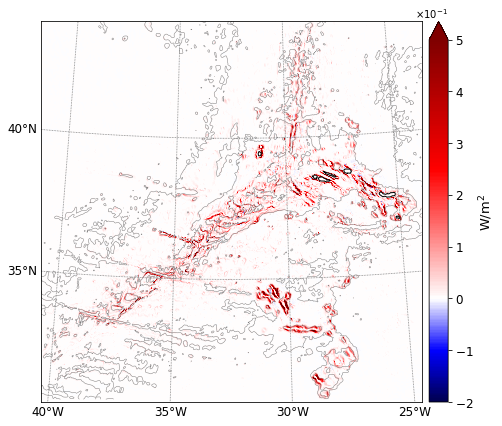

In [38]:
### parameters for plotting
picdir = 'pictures/'
toplot = C_t.T
hplot = -h_t.T
mask = (hplot<10)

fs       = 12
proj     = 'lcc'
res      = 'i'
stride   = 5
Lx,Ly    = 1500e3,1500e3 # extend in m
cmap = plt.get_cmap('seismic')
zlevs=[0,2000,3500]
topocol='k'     # isobath. contour color
grdcol='gray'   # grid color
mascale = 'linear'# "log" # 

if mascale == "linear":
    valmax = 0.5
    valmin = -0.2
elif mascale == 'log':
    valmin = 1e-6
    valmax = 0.1
    levels = np.logspace(np.log10(valmin),np.log10(valmax),11)

### do the plot
fig = plt.figure(figsize=(8,7))
ax = plt.subplot(111)
bm = Basemap(projection=proj,resolution=res,lon_0=lon_h.mean(),
        lat_0=lat_h.mean(),width=Lx,height=Ly)
xx, yy = bm(lon_h.T, lat_h.T)
bm.drawcoastlines(color='black')
bm.fillcontinents(color='white')
bm.drawparallels(np.arange(-60,70,stride),labels=[1,0,0,0],linewidth=0.8,\
                fontsize=fs,color=grdcol)
bm.drawmeridians(np.arange(-100,100,stride),labels=[0,0,0,1],linewidth=0.8,\
                fontsize=fs,color=grdcol)

bm.contour(xx,yy,hplot,zlevs,colors=topocol,linewidths=0.5,alpha=0.5)
if mascale == 'linear':
    hpc = bm.pcolormesh(xx,yy,np.ma.masked_array(toplot,mask),vmax=valmax,\
                      vmin=valmin,norm=norm,cmap=cmap)
    hcb = bm.colorbar(hpc,extend='max')
    hcb.formatter.set_powerlimits((-1, 1))
    hcb.formatter.set_useMathText(True)
    #cb.set_ticks(np.arange(-0.2,0.6,0.1))
    hcb.update_ticks()
elif mascale == 'log':
    hpc = bm.contourf(xx,yy,np.ma.masked_array(toplot,mask),levels,cmap=cmap,norm = LogNorm(),linestyles=None)
    hcb = bm.colorbar(hpc)
#for item in hpc.collections:
#    item.set_rasterized('True')
hcb.ax.tick_params(labelsize=fs)

hcb.set_label(r'$W/m^2$',fontsize=fs+1)    
plt.savefig(picdir+'Ct_LUCKY_TPXO8_{}.png'.format(mascale),magnification='auto',dpi=200,bbox_inches='tight')

In [49]:
# total conversion (integrated over the domain)
Ctot = np.nansum(C_t*dx_h*dy_h)
print('total conversion is {:.2f} GW'.format(Ctot/1e9))
print(r'domain averaged: {:.2f} mW/m$^2$'.format(Ctot/np.sum(dx_h*dy_h)*1e3))

total conversion is 15.67 GW
domain averaged: 6.98 mW/m$^2$


748.26245306295448